In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

### Custom Functions

In [3]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False) 
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

In [4]:
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
 
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index 
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

### Load Data

In [5]:
# import statsmodels base api module for the data
import statsmodels.api as sm
co2_data = sm.datasets.co2.load_pandas()
df = co2_data.data
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


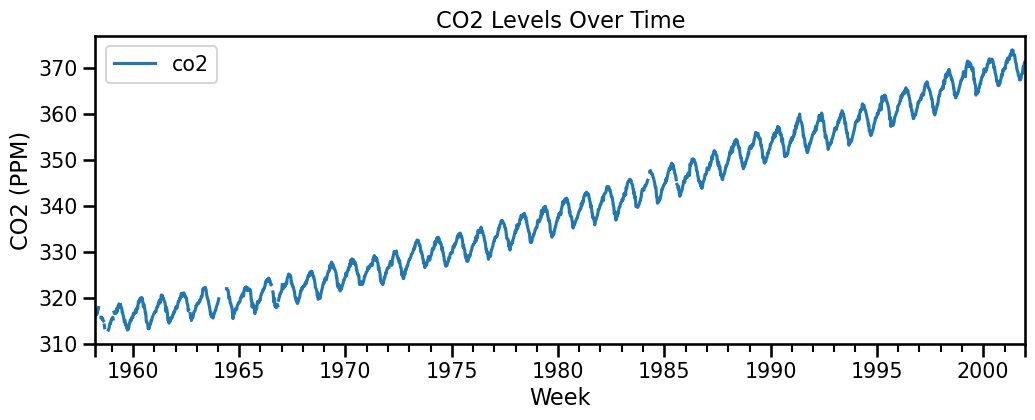

In [6]:
# Visualize the data
ax = df.plot()
ax.set(ylabel="CO2 (PPM)", xlabel="Week", title="CO2 Levels Over Time");

### Address Null Values

In [7]:
# Check for null values
df.isna().sum()

co2    59
dtype: int64

In [8]:
# Impute null values
df = df.interpolate()
df.isna().sum()

co2    0
dtype: int64

Create a t-1 column with .shift()

Now, we will manually create columns of data with the lags. For the t-1 column, we are essentially shifting the values by 1 row. We can employ the .shift() with a value of (1) to create a column representing the values at one lag.

In [9]:
# Let's add a column with the values from the previous week (one lag)
df["t-1"] = df["co2"].shift(1)
df.head()

,co2,t-1
1958-03-29,316.1,NaN
1958-04-05,317.3,316.1
1958-04-12,317.6,317.3
1958-04-19,317.5,317.6
1958-04-26,316.4,317.5


Take a moment to inspect the results. The first value is NaN, which is expected since we do not have any data prior to this date. The lag-1 for 1958-04-05 is the value from the previous row (316.1).

Create 4 lag columns with a for loop

Let's create 4 total time lags for our data. Rather than repeating the code from above multiple times, we will do this more efficiently by using a for loop:

In [10]:
# Loop to add columns with lags 1-4
for i in range(1, 5):
    df[f"t-{i}"] = df["co2"].shift(i)
df

,co2,t-1,t-2,t-3,t-4
1958-03-29,316.1,NaN,NaN,NaN,NaN
1958-04-05,317.3,316.1,NaN,NaN,NaN
1958-04-12,317.6,317.3,316.1,NaN,NaN
1958-04-19,317.5,317.6,317.3,316.1,NaN
1958-04-26,316.4,317.5,317.6,317.3,316.1
...,...,...,...,...,...
2001-12-01,370.3,370.3,369.7,368.8,368.7
2001-12-08,370.8,370.3,370.3,369.7,368.8
2001-12-15,371.2,370.8,370.3,370.3,369.7
2001-12-22,371.3,371.2,370.8,370.3,370.3


Notice that, now that we have included 4 time lags backward in time as "features," we only have complete data for t-1 to t-4 starting on our 5th row: 1958-04-26.

So, we need to drop the earliest observations from our model since we do not have any prior values, and the lags are null.

In [11]:
# Dropping early rows with NA values
df_model = df.dropna()
df_model

,co2,t-1,t-2,t-3,t-4
1958-04-26,316.4,317.5,317.6,317.3,316.1
1958-05-03,316.9,316.4,317.5,317.6,317.3
1958-05-10,317.2,316.9,316.4,317.5,317.6
1958-05-17,317.5,317.2,316.9,316.4,317.5
1958-05-24,317.9,317.5,317.2,316.9,316.4
...,...,...,...,...,...
2001-12-01,370.3,370.3,369.7,368.8,368.7
2001-12-08,370.8,370.3,370.3,369.7,368.8
2001-12-15,371.2,370.8,370.3,370.3,369.7
2001-12-22,371.3,371.2,370.8,370.3,370.3


Prepare data for traditional Linear Regression

In [12]:
# Our target is co2, the actual value for that rows' date
y = df_model["co2"]
X = df_model.drop(columns="co2")
X

,t-1,t-2,t-3,t-4
1958-04-26,317.5,317.6,317.3,316.1
1958-05-03,316.4,317.5,317.6,317.3
1958-05-10,316.9,316.4,317.5,317.6
1958-05-17,317.2,316.9,316.4,317.5
1958-05-24,317.5,317.2,316.9,316.4
...,...,...,...,...
2001-12-01,370.3,369.7,368.8,368.7
2001-12-08,370.3,370.3,369.7,368.8
2001-12-15,370.8,370.3,370.3,369.7
2001-12-22,371.2,370.8,370.3,370.3


Validation Split for Time Series

Since our data set is organized based on time, we will not perform a traditional train-test-split. Instead of using a random distribution of 75% of the rows as the training data, we will take the earliest 75% as our training data and leave the most recent 25% as our test data.

We will find the index value corresponding to 75% of the length of the data set. We will round to the whole number to ensure we get an integer value.

In [13]:
# calculating integer index for 75%/25% split
idx_split = round(len(X) * 0.75)
idx_split

1710

In [14]:
# What date corresponds to 75%?
split_date = X.index[idx_split]
split_date

Timestamp('1991-02-02 00:00:00', freq='W-SAT')

Okay, so we will use all observations from the beginning of the dataset to 1991-02-02 as our training data. All values after that will be part of our testing set.

In [15]:
# Time Series train-test-split
# All data before split date is training
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]
# All data after split date is testing
X_test = X.loc[split_date:]
y_test = y.loc[split_date:]

Let's plot our y_train and y_test to visualize the result of the train-test-split.

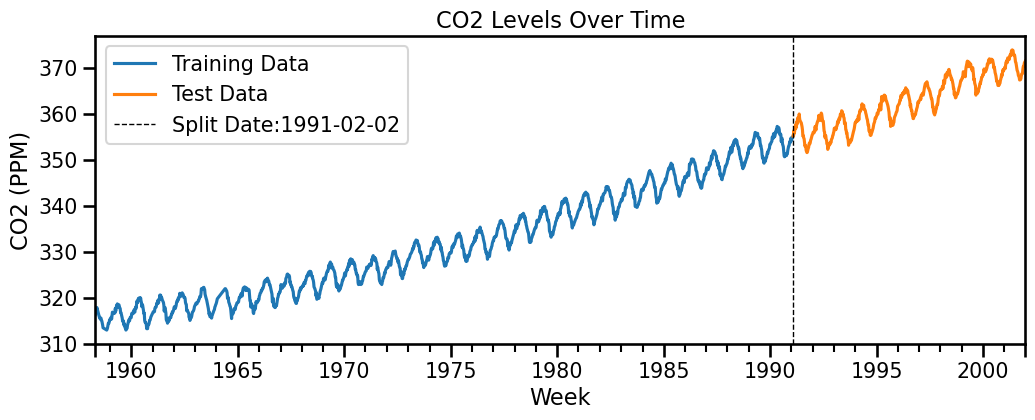

In [16]:
# Plotting the training and test data
ax = y_train.plot(label="Training Data")
y_test.plot(ax=ax, label="Test Data")
# Saving the date as a string for matplotlib
split_date_str = split_date.strftime("%Y-%m-%d")
# Annotating the split data
ax.axvline(
    split_date_str, color="black", ls="--", lw=1.0, label=f"Split Date:{split_date_str}"
)
ax.set(ylabel="CO2 (PPM)", xlabel="Week", title="CO2 Levels Over Time")
ax.legend();

#### Instantiate and Fit the Model

In [17]:
# Instantiate a Linear Regression Model
lin_reg = LinearRegression()
# Fit on the training data
lin_reg.fit(X_train, y_train)

LinearRegression()

Obtain Predictions

Now, we will obtain the predictions. We will organize them in a Pandas Series

In [18]:
# Making a Series of our test predictions
y_pred_test = lin_reg.predict(X_test)
y_pred_test = pd.Series(y_pred_test, index=y_test.index)
y_pred_test

1991-02-02    355.160974
1991-02-09    355.254278
1991-02-16    355.280741
1991-02-23    356.473156
1991-03-02    355.957149
                 ...    
2001-12-01    370.452759
2001-12-08    370.639149
2001-12-15    370.967720
2001-12-22    371.257917
2001-12-29    371.488852
Freq: W-SAT, Length: 570, dtype: float64

Let's plot our predictions along with our training and test values.

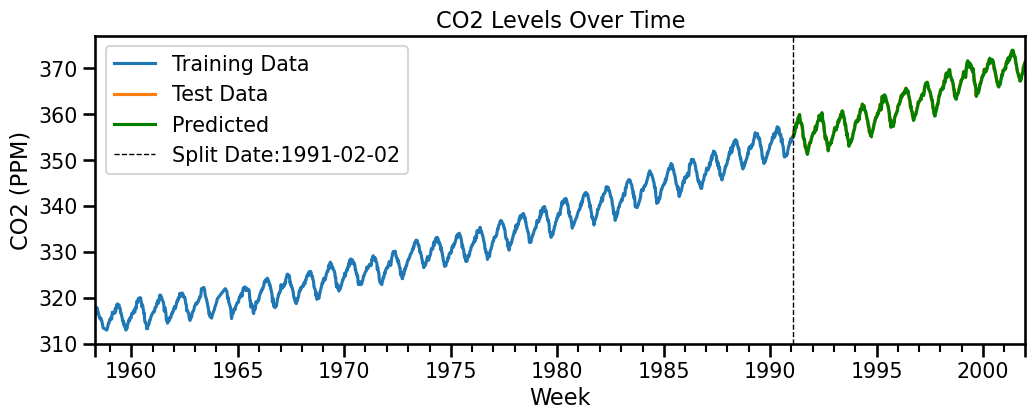

In [19]:
# Plotting the training and test data and predictions for test
ax = y_train.plot(label="Training Data")
y_test.plot(ax=ax, label="Test Data")
y_pred_test.plot(ax=ax, label="Predicted", color="green")
# Saving the date as a string for matplotlib
split_date_str = split_date.strftime("%Y-%m-%d")
# Annotating the split data
ax.axvline(
    split_date_str, color="black", ls="--", lw=1.0, label=f"Split Date:{split_date_str}"
)
ax.set(ylabel="CO2 (PPM)", xlabel="Week", title="CO2 Levels Over Time")
ax.legend();

The plot indicates that our prediction was very close to the test values as the green predicted values completely overlap the orange test data. Let's obtain the numerical values for evaluating a regression model.

Evaluate

We will use our custom functions to evaluate the model. Be sure to define these in your notebook before calling them.

In [20]:
# Getting predictions and metrics
evaluate_regression(lin_reg, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 0.344
- MSE = 0.198
- RMSE = 0.445
- R^2 = 0.999

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 0.381
- MSE = 0.239
- RMSE = 0.489
- R^2 = 0.992


Our model performance seems amazing! However, there is an important consideration here:

We haven't technically created a model to forecast into the future; we created a model to predict only one step ahead based on the TRUE values for the previous 4 steps in time.

Predicting vs. Forecasting

We have generated what are called "one-step-ahead" predictions. Even for our test predictions, for each date that we predicted, we used the actual known values from the previous 4 lags.

This means we could never predict more than 1 week into the future with our model. It will always need to know the previous 4 weeks' CO2 levels to predict 1 week into the future.

With time series models, we almost always need to predict more than 1 step into the future.

To accomplish this, we need a new type of model, which is designed to make a true "dynamic forecast" into the future, where it uses its own predicted values for the test data to predict the next time lag.

# Stationarity

White Noise Time Series

A white noise time series is a continuous time series of random values with a constant mean and variance. They are normally and independently distributed and do not show autocorrelation (we will discuss autocorrelation in the next lesson). In other words, there is no overall trend or pattern in the values.

We can create a mathematical model for a white noise time series:

For this example, we are using an additive white noise time series, where the random value is added or subtracted. At a particular time, t, the value is simply the baseline value +/- a random value.

(There is also a multiplicative version of a white noise time series, in which they are multiplied together.)

We can manually construct a white noise time series.

For our example, imagine that we are measuring how many minutes it takes a bus driver to complete 1 lap of their bus route. The transit authority says that the route should take 49 minutes. However, the route can take several minutes longer or shorter due to unpredictable events such as traffic lights, road closures, traffic, etc.

Let's simulate measuring the time to complete the bus route over 120 laps.

The baseline value, c, is 49.

### Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import  statsmodels.tsa.api as tsa # new import
from sklearn import set_config
#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)

We will calculate the random change in route time for each day using Numpy's random.normal function, which will select a random value from a normal distribution. We will add the random value to the mean of 49 to get the duration of the bus lap for the day.

In [22]:
# Calculating a simulated white noise time series (one value)
c = 49
noise_t = np.random.normal()
# Add the random value to the mean to get the duration of the lap for one day
y_t= c + noise_t
y_t

49.17251946894025

Now we will use a loop to simulate the entire 120 days

In [23]:
# Calculating a simulated white noise time series for 120 days
c = 49
n_lags = 120
y = []
for t in range(n_lags):
    
    noise_t = np.random.normal(size=1)
    y_t = c + noise_t[0] # slicing 0 to get value instead of arrays
    y.append(y_t)

Now we will convert the list of values to a Pandas series.

In [24]:
# Convet list to a Pandas Series
ts_white_noise = pd.Series(y, name='Simulated White Noise')     
ts_white_noise

0      50.635483
1      49.037336
2      48.115850
3      47.856808
4      48.378634
         ...    
115    50.081623
116    49.227369
117    50.421600
118    48.683405
119    47.880499
Name: Simulated White Noise, Length: 120, dtype: float64

Plotting the White Noise Time Series

Plotting can be especially helpful in understanding time series data. Below we are just plotting the simulated time series we created.

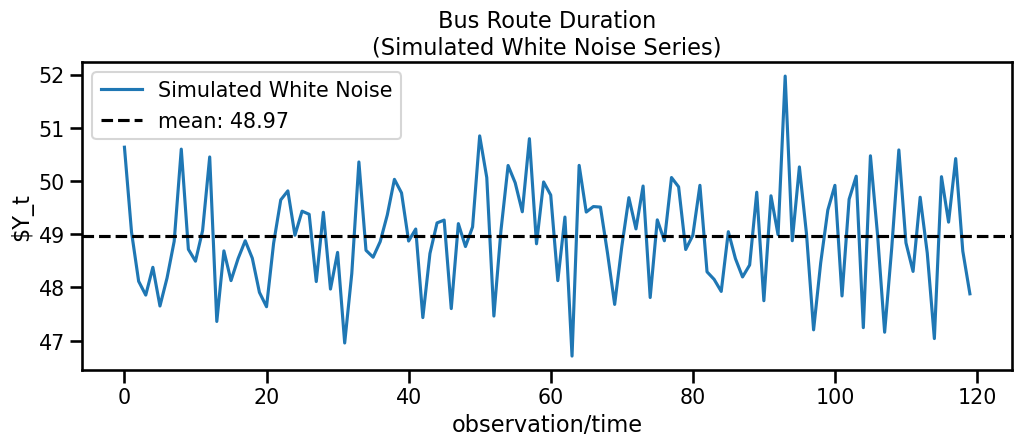

In [33]:
# Plotting the white noise series with annotated mean
ax = ts_white_noise.plot()
ax.set(title='Bus Route Duration\n(Simulated White Noise Series)',
       ylabel='$Y_t', xlabel="observation/time");
ax.axhline( ts_white_noise.mean(),  color='k', ls='--',
           label=f'mean: {ts_white_noise.mean():.2f}');
ax.legend();

In this case, we purposefully created a white noise time series to demonstrate a stationary dataset. In reality, we would start with an existing dataset and then need to determine if it is stationary (or not).

We will show how to confirm that this dataset is stationary.

We must confirm there is a constant (stationary) mean and a constant (stationary) variance.

Rather than relying on a visualization to check for constant mean and variance, we can use a statistical test, the Augmented Dickey-Fuller Test.

### Augmented Dickey-Fuller Test

If we check the documentation for adfuller we can see that it returns a lot of important information, including:

adf (float): The test statistic
pvalue: p-value (what we care about the most)
usedlag : The number of lags/time steps used.
nobs : number of observations used.
critical values (dict) Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
and some additional metrics.
Let's run the test on our white noise model.

In [34]:
# Running the adfuller test to demonstrate return
tsa.adfuller(ts_white_noise)

(-11.133859534698885,
 3.2317307055656125e-20,
 0,
 119,
 {'1%': -3.4865346059036564,
  '5%': -2.8861509858476264,
  '10%': -2.579896092790057},
 295.21163114049114)

Unfortunately, it returns the results as separate variables.

First, let's save each output separately.

In [35]:
# Saving each output separately
(test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts_white_noise)

Now, we will select the most important results and include them in a dictionary.

In [36]:
# Saving the most important results as a dictionary
adfuller_results = {'Test Statistic': test_stat,
                    "# of Lags Used":nlags, 
                   '# of Observations':nobs,
                    'p-value': round(pval,6)}

To aid in interpretation, we will also include an entry to indicate whether or not the test had a significant p-value or not, and what this means in terms of stationarity. We will define alpha as 0.05.

In [37]:
# Adding interpretation of p-value to dictionary
alpha =.05
adfuller_results['sig/stationary?'] = pval < alpha
adfuller_results

{'Test Statistic': -11.133859534698885,
 '# of Lags Used': 0,
 '# of Observations': 119,
 'p-value': 0.0,
 'sig/stationary?': True}

The final step is to convert the dictionary to a dataframe.

In [38]:
# Convert dictionary of results to a dataframe
adfuller_df = pd.DataFrame(adfuller_results, index=['AD Fuller Test'])
adfuller_df

,Test Statistic,# of Lags Used,# of Observations,p-value,sig/stationary?
AD Fuller Test,-11.13386,0,119,0.0,True


We now have a much easier-to-read output and can confirm that our white noise time series is indeed stationary according to the Ad Fuller Test.

Because we will want to perform the Ad Fuller test many times, we will combine the above steps into a custom function. We will allow the option to change the alpha value and set the default to 0.05. We will also include **kwargs so we can modify the arguments of the adfuller() test if needed.

In [39]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [40]:
# Testing the function
adfuller_results = get_adfuller_results(ts_white_noise, label='White Noise')
adfuller_results

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
White Noise,-11.13386,0,119,0.0,0.05,True


# Autocorrelation

Checking for Autocorrelation with 1 time lag

First, we will manually create a column for 1 lag using .shift().

In [41]:
# Shift the data one step 
ts_lag1 = ts_white_noise.shift(1)
ts_lag1 = ts_lag1.rename('Lag 1')
ts_lag1.head()

0          NaN
1    50.635483
2    49.037336
3    48.115850
4    47.856808
Name: Lag 1, dtype: float64

Now, combine this with the original values.

In [42]:
# Combine original ts + with lag 1
ts_lagged = pd.concat([ts_white_noise,ts_lag1], axis=1)
ts_lagged.head()

,Simulated White Noise,Lag 1
0,50.635483,NaN
1,49.037336,50.635483
2,48.115850,49.037336
3,47.856808,48.115850
4,48.378634,47.856808


Now, we will check for a correlation between the original value and the first lag.

In [43]:
# Checking for correlation
ts_lagged.corr()

,Simulated White Noise,Lag 1
Simulated White Noise,1.000000,-0.021783
Lag 1,-0.021783,1.000000


The autocorrelation at lag 1 is almost 0, which is what we would expect for a white noise time series.

When checking for autocorrelation, however, we will need to test more than just 1 time lag.

Checking for Autocorrelation with many time lags

We will use a loop to create columns for lags 0-20. (Notice that lag 0 is just the original value).

In [44]:
# Generate 20 time-shifted columns
ts_lagged = pd.DataFrame()
total_shifts = 20
for t in range(0,total_shifts+1):    
    ts_lagged[f"Lag {t}"] =  ts_white_noise.shift(t)
ts_lagged.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
0,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.856808,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48.378634,47.856808,48.115850,49.037336,50.635483,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we will calculate the correlation matrix for all values

In [45]:
# Calculate correlations for all values
corr = ts_lagged.corr()
corr.head()

,Lag 0,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,...,Lag 11,Lag 12,Lag 13,Lag 14,Lag 15,Lag 16,Lag 17,Lag 18,Lag 19,Lag 20
Lag 0,1.000000,-0.021783,-0.064080,-0.018734,-0.014180,-0.118503,0.018079,0.064780,-0.173773,-0.128825,...,0.058375,0.038630,-0.037089,0.075861,0.021654,0.175557,0.166579,-0.028704,-0.282454,-0.125067
Lag 1,-0.021783,1.000000,-0.024832,-0.050657,-0.016234,-0.002859,-0.141524,0.014664,0.073168,-0.182525,...,0.142978,0.056308,0.019034,-0.037182,0.094835,0.001457,0.191472,0.176576,-0.043111,-0.274006
Lag 2,-0.064080,-0.024832,1.000000,-0.021312,-0.050016,-0.013321,-0.008398,-0.142619,0.016912,0.071255,...,-0.127894,0.142397,0.051440,0.019082,-0.032922,0.090528,0.005322,0.194548,0.173809,-0.039859
Lag 3,-0.018734,-0.050657,-0.021312,1.000000,-0.025063,-0.066142,0.013100,-0.003901,-0.154446,0.026492,...,-0.210015,-0.126081,0.172880,0.051795,-0.002686,-0.007229,0.074885,-0.005278,0.215711,0.161757
Lag 4,-0.014180,-0.016234,-0.050016,-0.025063,1.000000,-0.028093,-0.062291,0.013955,-0.005708,-0.153189,...,0.071136,-0.209615,-0.123666,0.172903,0.048696,0.001656,-0.010319,0.073314,-0.002383,0.214486


For autocorrelation, we are specifically interested in lags correlated to the original value (Lag 0), so we will slice out the first column.

In [46]:
# Slice out the original ts (lag 0)
auto_corr = corr['Lag 0']
auto_corr

Lag 0     1.000000
Lag 1    -0.021783
Lag 2    -0.064080
Lag 3    -0.018734
Lag 4    -0.014180
Lag 5    -0.118503
Lag 6     0.018079
Lag 7     0.064780
Lag 8    -0.173773
Lag 9    -0.128825
Lag 10    0.122801
Lag 11    0.058375
Lag 12    0.038630
Lag 13   -0.037089
Lag 14    0.075861
Lag 15    0.021654
Lag 16    0.175557
Lag 17    0.166579
Lag 18   -0.028704
Lag 19   -0.282454
Lag 20   -0.125067
Name: Lag 0, dtype: float64

We will plot the correlation values to aid in interpreting the results.

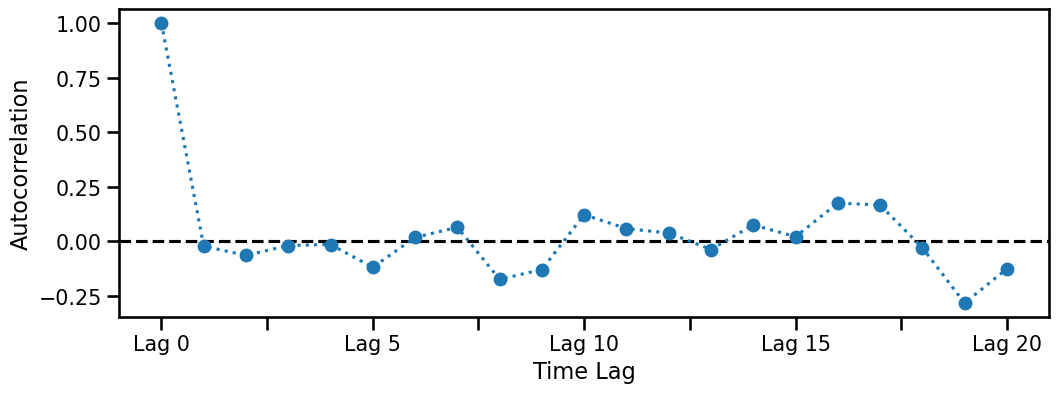

In [47]:
# Plot the calculated correlations
ax = auto_corr.plot(style='o:')
ax.axhline(0, color='k', ls='--', zorder=-1);
ax.set(ylabel='Autocorrelation', xlabel='Time Lag');

We can see in our graph above that, as we would expect, lag 0 is perfectly correlated since it is the same data.

We see that the correlation for lag 1 plummets to near 0. Additionally, the other lags stay roughly near 0.

We had to perform quite a bit of effort to get this visualization, but now that you understand the concept, there's an easier way: using statsmodels plot_acf function.

### Statsmodels plot_acf
Let's visually check for autocorrelation using the .plot_acf function. Simply include the original time series as the argument when calling the function. This will produce an ACF plot.

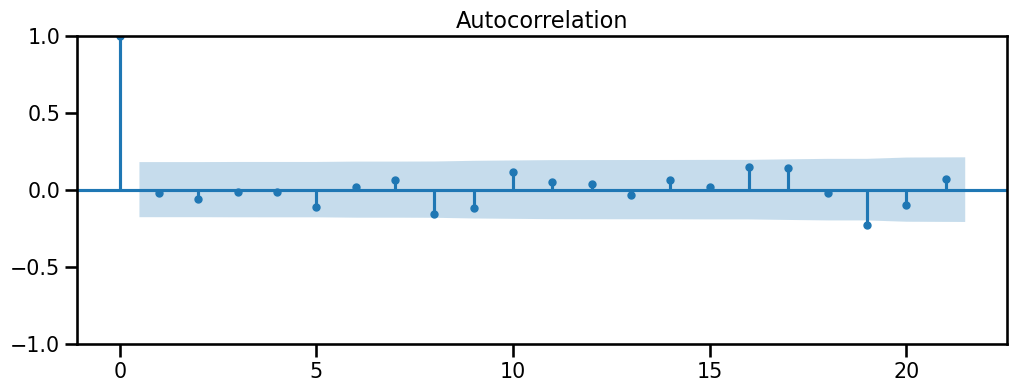

In [48]:
# Plotting autocorrelation with built in function
fig = tsa.graphics.plot_acf(ts_white_noise);

Before moving on, take time to compare the results from the built-in function to the results we plotted above. Do you see how the plots are showing the same information, only with a slightly different style?

We can see that the statsmodels version looks similar to ours, except that the markers are not connected by a line, and a shaded region has been added to all of the time lags after 0.

As long as the correlation values stay mostly within the shaded region, we can conclude that there is no autocorrelation.

Between our Augmented Dickey-Fuller test results and the ACF plot, we can confirm that this simulated time series is indeed stationary with no autocorrelation, which confirms that it is a white noise time series.

## Random Walk Time Series
We have explored a white noise time series as stationary time series with no autocorrelation. In contrast, we will now introduce a fundamental time series known as a random walk. The following are key properties of a random walk:

Random walks are Not stationary.
Random walks have significant Autocorrelation.
Differencing a random walk time series creates a white-noise time series.
A random walk time series is similar to a white noise time series in that one of the components is a random value. The difference, though, is that a random walk model combines the random value with the previous time lag's value (vs. white noise, where a constant baseline value is used for every time lag).

We will now create a simulated random walk time series. We will start with an arbitrary value of 150. Then, a random value will be selected with np.random.normal. This value will be added to the first value. This process will repeat for 120 time steps.

In [49]:
# Calculating a simulated random walk 
first_t = 150
y_walk = [first_t]
n_lags=120
for t in range(1,n_lags):
    # get the previous time lag's value
    y_prev_t = y_walk[t-1]
    
    # Get new noise
    noise_t = np.random.normal(size=1)
    
    # Add noise on to previous value
    y_t = y_prev_t + noise_t[0] # slicing 0 to get value instead of arrays
    y_walk.append(y_t)
    
ts_rand_walk = pd.Series(y_walk, name='Simulated Random Walk')    
ts_rand_walk

0      150.000000
1      148.598865
2      147.131094
3      148.014590
4      147.161973
          ...    
115    153.871576
116    152.788941
117    153.142111
118    155.103555
119    155.816590
Name: Simulated Random Walk, Length: 120, dtype: float64

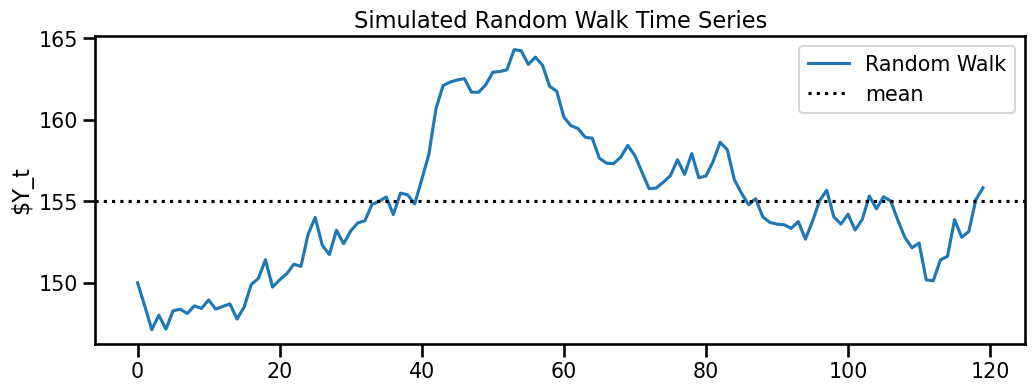

In [55]:
# Visualize the random walk time series
ax = ts_rand_walk.plot(label='Random Walk')
ax.set(ylabel= '$Y_t', title="Simulated Random Walk Time Series");
ax.axhline(ts_rand_walk.mean(), color='black', ls=':', label='mean');
ax.legend();

In [56]:
# Test random walk for stationarity
get_adfuller_results(ts_rand_walk)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.442588,0,119,0.561697,0.05,False


### Create ACF Plot for Random Walk

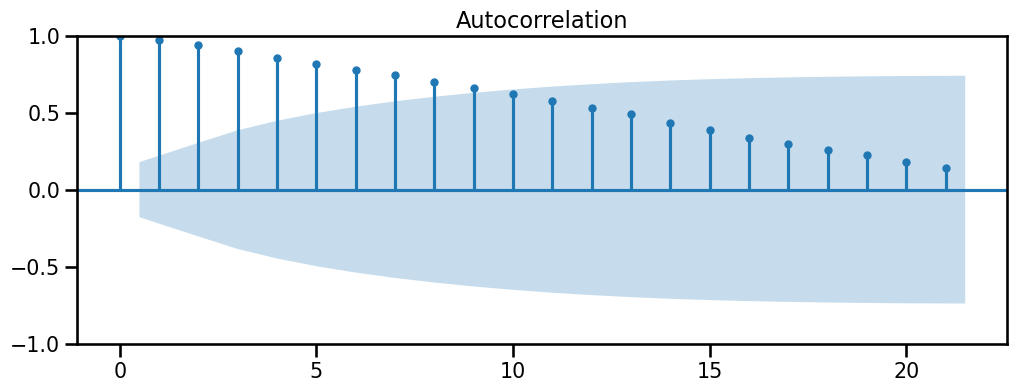

In [57]:
# Check for autocorrelation
tsa.graphics.plot_acf(ts_rand_walk);